In [1]:
%matplotlib inline

# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models, feats
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)
importlib.reload(feats)

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

import glob
import os
import json

import time
import datetime as dt
from tqdm.auto import tqdm
from IPython.display import clear_output, display

In [2]:
df_sign = pd.read_csv(params.sign_csv, index_col=0, parse_dates=True) 

# Collect each day’s feature-engineered frame
frames = []
print('generating main features...')
for day, day_df in df_sign.groupby(df_sign.index.normalize()):
    # day_df has only that session’s bars
    feats_main = feats.features_creation(df = day_df, 
                                         ma_window = 20) # sma window for ATR and Volume
    frames.append(feats_main)

# Re-assemble back into one long DF
df_feat_main = pd.concat(frames).sort_index()

print('generating engineered features...')
df_feat_eng = feats.features_engineering(
                                        df = df_feat_main,
                                        low_rsi = 30,
                                        high_rsi = 70,
                                        adx_thresh = 20,
                                        adx_window = 7
                                        )

df_feat_eng

generating main features...
generating engineered features...


,ema,sma,macd_line,macd_signal,macd_diff,bb_lband,bb_hband,bb_width_20,rsi,plus_di,minus_di,adx,atr_14,atr_sma,atr_ratio,atr_ratio_sma,obv,obv_sma,vwap_dev,r_1,r_5,r_15,vol_15,volume_spike,stoch_k_14,stoch_d_3,hour,day_of_week,month,open,high,low,close,volume,bid,ask,signal,eng_ma,eng_macd,eng_bb,eng_rsi,eng_adx,eng_obv,eng_atr_div
2004-01-02 13:20:00,0.764135,0.764218,-0.000055,-0.000039,-0.000016,0.764037,0.764359,0.000422,0.000000,0.000000,100.000000,100.000000,0.000011,0.000005,0.000014,0.000006,-1066843.75,-3.064250e+05,-0.000280,-0.000022,-0.000110,-0.000307,0.000010,1.927594,0.000000,0.000000,13,4,1,0.764051,0.764051,0.764051,0.764051,121712.50,0.763480,0.764623,0.780245,-0.000,-0.000,0.000,30.000,-0.000,-7.604188e+05,0.1
2004-01-02 13:21:00,0.764119,0.764208,-0.000059,-0.000043,-0.000016,0.764015,0.764356,0.000447,0.000000,0.000000,100.000000,100.000000,0.000011,0.000005,0.000015,0.000007,-1195250.00,-3.675875e+05,-0.000297,-0.000022,-0.000110,-0.000329,0.000010,1.883825,0.000000,0.000000,13,4,1,0.764035,0.764035,0.764035,0.764035,128406.25,0.763463,0.764606,0.804486,-0.000,-0.000,0.000,30.000,-0.000,-8.276625e+05,0.1
2004-01-02 13:22:00,0.764104,0.764198,-0.000062,-0.000047,-0.000016,0.763993,0.764351,0.000468,0.000000,0.000000,100.000000,100.000000,0.000012,0.000006,0.000015,0.000008,-1330350.00,-4.355050e+05,-0.000314,-0.000022,-0.000110,-0.000329,0.000009,1.837658,0.000000,0.000000,13,4,1,0.764018,0.764018,0.764018,0.764018,135100.00,0.763446,0.764589,0.829493,-0.000,-0.000,0.000,30.000,-0.000,-8.948450e+05,0.1
2004-01-02 13:23:00,0.764088,0.764187,-0.000066,-0.000050,-0.000016,0.763972,0.764343,0.000486,0.000000,0.000000,100.000000,100.000000,0.000012,0.000006,0.000016,0.000008,-1472143.75,-5.105122e+05,-0.000330,-0.000022,-0.000110,-0.000329,0.000008,1.790163,0.000000,0.000000,13,4,1,0.764001,0.764001,0.764001,0.764001,141793.75,0.763430,0.764573,0.855291,-0.000,-0.000,0.000,30.000,-0.000,-9.616316e+05,0.1
2004-01-02 13:24:00,0.764072,0.764176,-0.000069,-0.000054,-0.000015,0.763952,0.764333,0.000498,0.000000,0.000000,100.000000,100.000000,0.000012,0.000007,0.000016,0.000009,-1620631.25,-5.929438e+05,-0.000346,-0.000022,-0.000110,-0.000329,0.000007,1.742166,0.000000,0.000000,13,4,1,0.763984,0.763984,0.763984,0.763984,148487.50,0.763413,0.764556,0.881905,-0.000,-0.000,0.000,30.000,-0.000,-1.027688e+06,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.464247,196.252523,0.175662,0.134526,0.041136,195.926584,196.725006,0.004067,67.216594,36.312473,7.485222,30.194416,0.250991,0.185279,0.001275,0.000944,3774929.00,2.674136e+06,0.002191,0.000635,0.002846,0.003639,0.000724,1.952858,62.051653,56.011167,20,2,6,196.680000,196.860000,196.630000,196.815000,385695.00,196.667400,196.962600,0.400199,0.212,0.041,-0.090,-37.217,10.194,1.100793e+06,3.3
2025-06-18 20:57:00,196.496671,196.279250,0.179462,0.143513,0.035949,195.924930,196.772160,0.004315,61.668579,34.720671,6.704415,32.868467,0.260206,0.189361,0.001323,0.000964,3314299.00,2.716659e+06,0.001453,-0.000712,0.001450,0.003081,0.000746,2.143635,64.412431,61.090338,20,2,6,196.810000,196.940000,196.560000,196.675000,460630.00,196.527500,196.822500,0.387662,0.217,0.036,0.097,-31.669,12.868,5.976403e+05,3.6
2025-06-18 20:58:00,196.523337,196.306558,0.179996,0.150810,0.029186,195.925348,196.812742,0.004519,61.473426,33.627161,6.493263,35.351515,0.249477,0.193049,0.001269,0.000983,2789054.00,2.726865e+06,0.001403,-0.000025,0.000559,0.002291,0.000747,2.234218,62.942847,63.135644,20,2,6,196.675000,196.740000,196.630000,196.670000,525245.00,196.522500,196.817500,0.377083,0.217,0.029,0.143,-31.473,15.352,6.218915e+04,2.9
2025-06-18 20:59:00,196.479747,196.318096,0.144060,0.149460,-0.005400,195.922319,196.812771,0.004535,47.540108,29.057762,16.002074,34.895986,0.268085,0.197973,0.001366,0.001008,713551.00,2.628833e+06,-0.000791,-0.

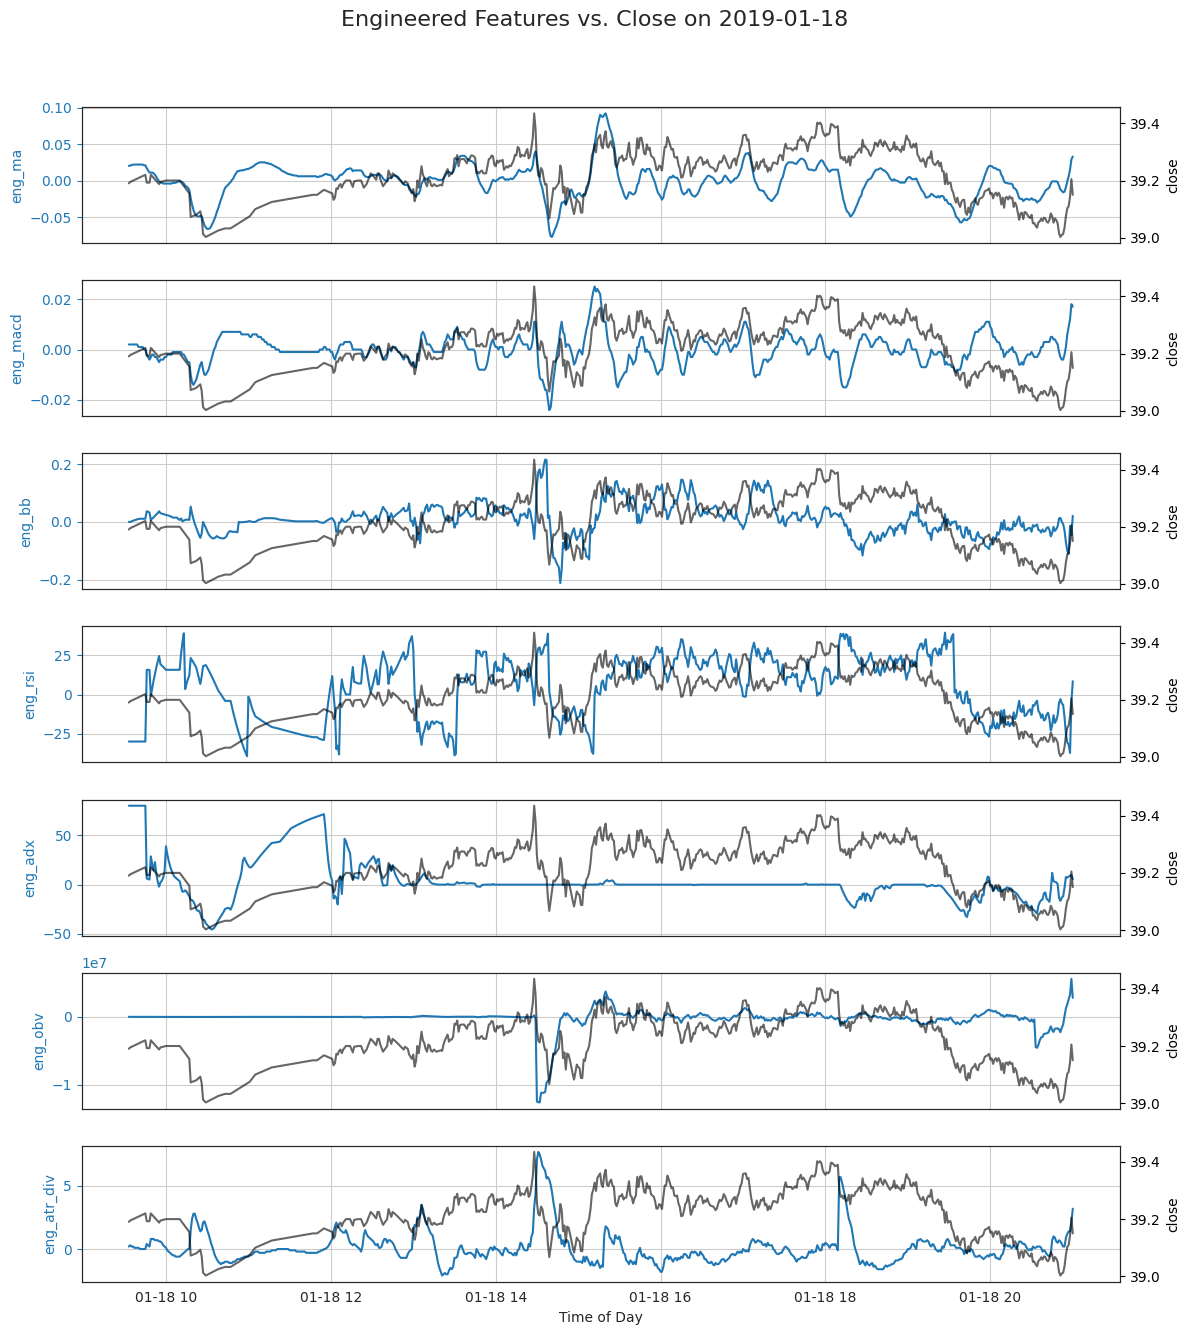

In [3]:
# 1) Identify engineered‐feature columns and the raw close price column
eng_features = [c for c in df_feat_eng.columns if c.startswith("eng_")]
close_col    = "close"

# 2) Pick a random trading day and convert to pandas Timestamp
all_days   = df_feat_eng.index.normalize().unique()
random_day = np.random.choice(all_days)
day_ts     = pd.to_datetime(random_day)

# 3) Subset the DataFrame to that single day
mask         = df_feat_eng.index.normalize() == random_day
df_day_feats = df_feat_eng.loc[mask, eng_features]
df_day_close = df_feat_eng.loc[mask, close_col]

# 4) Create one subplot per engineered feature
fig, axes = plt.subplots(
    nrows   = len(eng_features),
    ncols   = 1,
    figsize = (12, 2 * len(eng_features)),
    sharex  = True
)
fig.suptitle(f"Engineered Features vs. Close on {day_ts.date()}", fontsize=16)

# 5) Plot each feature on its own left‐y axis, and close price on a right‐y axis
for ax, feat in zip(axes, eng_features):
    # left axis: engineered feature
    ax.plot(df_day_feats.index, df_day_feats[feat],
            color="C0", label=feat)
    ax.set_ylabel(feat, color="C0")
    ax.tick_params(axis="y", colors="C0")
    ax.grid(True)

    # right axis: raw close price
    ax2 = ax.twinx()
    ax2.plot(df_day_close.index, df_day_close,
             color="k", alpha=0.6, label="close")
    ax2.set_ylabel("close", color="k")
    ax2.tick_params(axis="y", colors="k")

# 6) Final formatting
axes[-1].set_xlabel("Time of Day")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


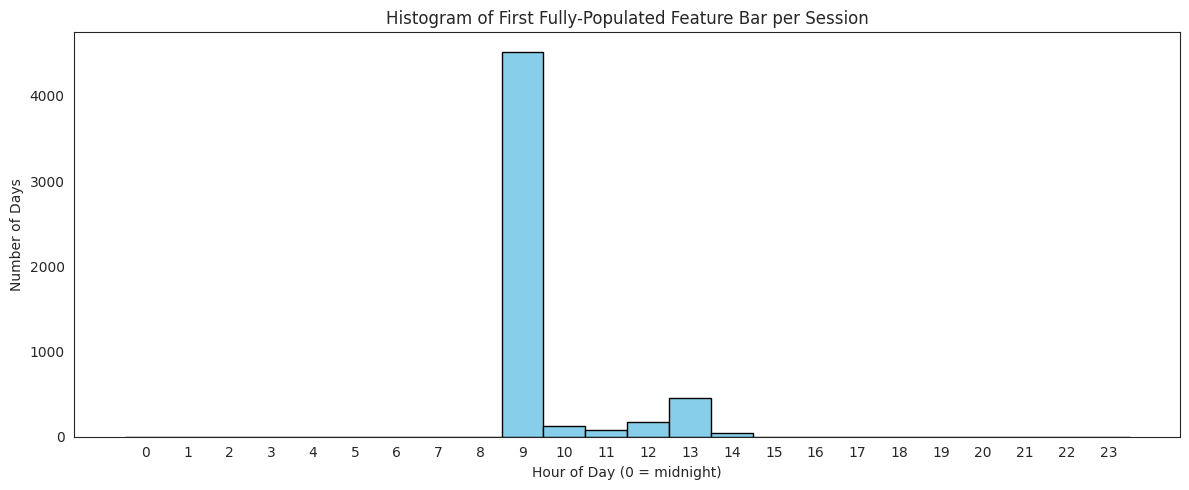

In [4]:
# -----------------------------------------------------------------------------
# What this plot shows:
#   We measure, for each trading day, the first 1-minute bar when *every* feature has a non-null value.  
#   Plotting the histogram of those hours tells how long the indicators take to “warm up” each morning before your model can run.
# -----------------------------------------------------------------------------

# 1) Prepare a DataFrame without bid/ask (and any non-feature cols)
df_feat_unsc = df_feat_eng.drop(columns=["bid", "ask"], errors="ignore")

# 2) Identify all feature columns (those starting with "feat_")
feat_cols = [c for c in df_feat_unsc.columns if c != 'signal']

# 3) For each calendar day, find the first timestamp where *all* feat_ cols are non-null
first_valid = (
    df_feat_unsc
      .groupby(df_feat_unsc.index.normalize())
      .apply(lambda grp: grp.dropna(subset=feat_cols).index.min())
)

# 4) Extract the hour (0–23) of that first fully-populated bar
first_valid_hours = first_valid.dt.hour

# 5) Plot the histogram
plt.figure(figsize=(12, 5))
plt.hist(
    first_valid_hours,
    bins=range(0, 25),       # 24 one-hour bins
    align='left',
    color='skyblue',
    edgecolor='black'
)
plt.xticks(range(0, 24))
plt.xlabel('Hour of Day (0 = midnight)')
plt.ylabel('Number of Days')
plt.title('Histogram of First Fully-Populated Feature Bar per Session')
plt.tight_layout()
plt.show()


In [5]:
# feed the trimmed DataFrame into the existing call
df_feat_all = feats.scale_with_splits(
    df           = df_feat_eng,
    train_prop   = params.train_prop,
    val_prop     = params.val_prop
)

Scaling splits:   0%|          | 0/3 [00:00<?, ?split/s]

Applying PCA:   0%|          | 0/3 [00:00<?, ?split/s]

In [6]:
print("saving df …")
df_feat_all.to_csv(params.feat_all_csv) # saving also bid and ask
df_feat_all

saving df …


,bb_lband,bb_hband,atr_14,atr_sma,obv,obv_sma,open,high,low,close,volume,r_1,r_5,r_15,vol_15,bb_width_20,rsi,atr_ratio,atr_ratio_sma,vwap_dev,volume_spike,stoch_k_14,stoch_d_3,eng_ma,eng_macd,eng_bb,eng_rsi,eng_adx,eng_obv,eng_atr_div,hour,day_of_week,month,bid,ask,signal
2004-01-02 13:20:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.029165,-0.067744,-0.112602,-0.997659,-0.838876,-2.494214,-0.989424,-0.997100,-0.073651,0.764638,-1.555525,-1.589223,-0.001454,0.001532,0.029493,1.505911,-0.027654,-0.184772,0.001872,0.510,-0.976,0.416,0.763480,0.764623,0.780245
2004-01-02 13:21:00,-1.000000,-1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-0.029165,-0.067746,-0.120543,-0.998730,-0.832336,-2.494214,-0.988729,-0.996170,-0.076976,0.723780,-1.555525,-1.589223,-0.001454,0.001532,0.029493,1.505911,-0.027654,-0.199896,0.001872,0.510,-0.976,0.416,0.763463,0.764606,0.804486
2004-01-02 13:22:00,-0.989613,-1.258113,0.962963,1.017212,-1.025403,-1.052332,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-0.029166,-0.067747,-0.120546,-1.000130,-0.826683,-2.494214,-0.988084,-0.995208,-0.080213,0.680682,-1.555525,-1.589223,-0.001454,0.001532,0.029493,1.505911,-0.027654,-0.215007,0.001872,0.510,-0.976,0.416,0.763446,0.764589,0.829493
2004-01-02 13:23:00,-0.980146,-1.295403,0.951510,1.021361,-1.033031,-1.068713,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-0.029167,-0.067748,-0.120548,-1.001950,-0.822092,-2.494214,-0.987484,-0.994215,-0.083364,0.636345,-1.555525,-1.589223,-0.001454,0.001532,0.029493,1.505911,-0.027654,-0.230028,0.001872,0.510,-0.976,0.416,0.763430,0.764573,0.855291
2004-01-02 13:24:00,-0.959905,-1.396263,0.928571,1.029833,-1.048349,-1.101550,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-0.029167,-0.067750,-0.120551,-1.004371,-0.818764,-2.494214,-0.986928,-0.993195,-0.086429,0.591539,-1.555525,-1.589223,-0.001454,0.001532,0.029493,1.505911,-0.027654,-0.244885,0.001872,0.510,-0.976,0.416,0.763413,0.764556,0.881905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,-0.273987,0.171313,1.490552,0.763585,0.810448,0.355966,0.514056,0.712871,0.507812,0.711270,5.457497,0.835764,1.741652,1.317454,0.348646,0.119859,0.817330,0.590045,0.188423,0.405541,0.788222,0.354270,0.171950,12.076104,10.569976,-2.703249,-1.809641,0.353707,0.233838,1.374807,-0.938,0.040,0.081,196.667400,196.962600,0.400199
2025-06-18 20:57:00,-0.277244,0.237613,1.595167,0.802457,0.615883,0.371696,0.714286,0.834646,0.390625,0.485397,6.617038,-0.936790,0.887168,1.115028,0.391490,0.185120,0.543997,0.649863,0.214541,0.262395,0.966313,0.426928,0.331656,12.360953,9.281142,2.974783,-1.535979,0.453742,0.120673,1.503520,-0.938,0.040,0.081,196.527500,196.822500,0.387662
2025-06-18 20:58:00,-0.275415,0.295487,1.471839,0.842586,0.391635,0.375126,0.498008,0.520710,0.501626,0.476825,7.618132,-0.033787,0.341858,0.828680,0.392127,0.238802,0.534383,0.581581,0.238137,0.252764,1.050873,0.381698,0.395967,12.360953,7.476773,4.371518,-1.526312,0.546669,0.000243,1.203190,-0.938,0.040,0.081,196.522500,196.817500,0.377083
2025-06-18 20:59:00,-0.278458,0.295307,1.671470,0.895459,-0.465725,0.333652,0.504000,0.537549,-0.110089,-0.205079,31.539808,-2.880849,-0.842461,-0.093777,0.692828,0.242909,-0.152067,0.703827,0.269879,-0.172745,4.759109,-0.182913,0.213033,9.227624,-1.287303,17.427955,-0.839051,0.240466,-0.444516,1.503520,-0.938,0.040,0.081,196.092800,196.387200,0.368386


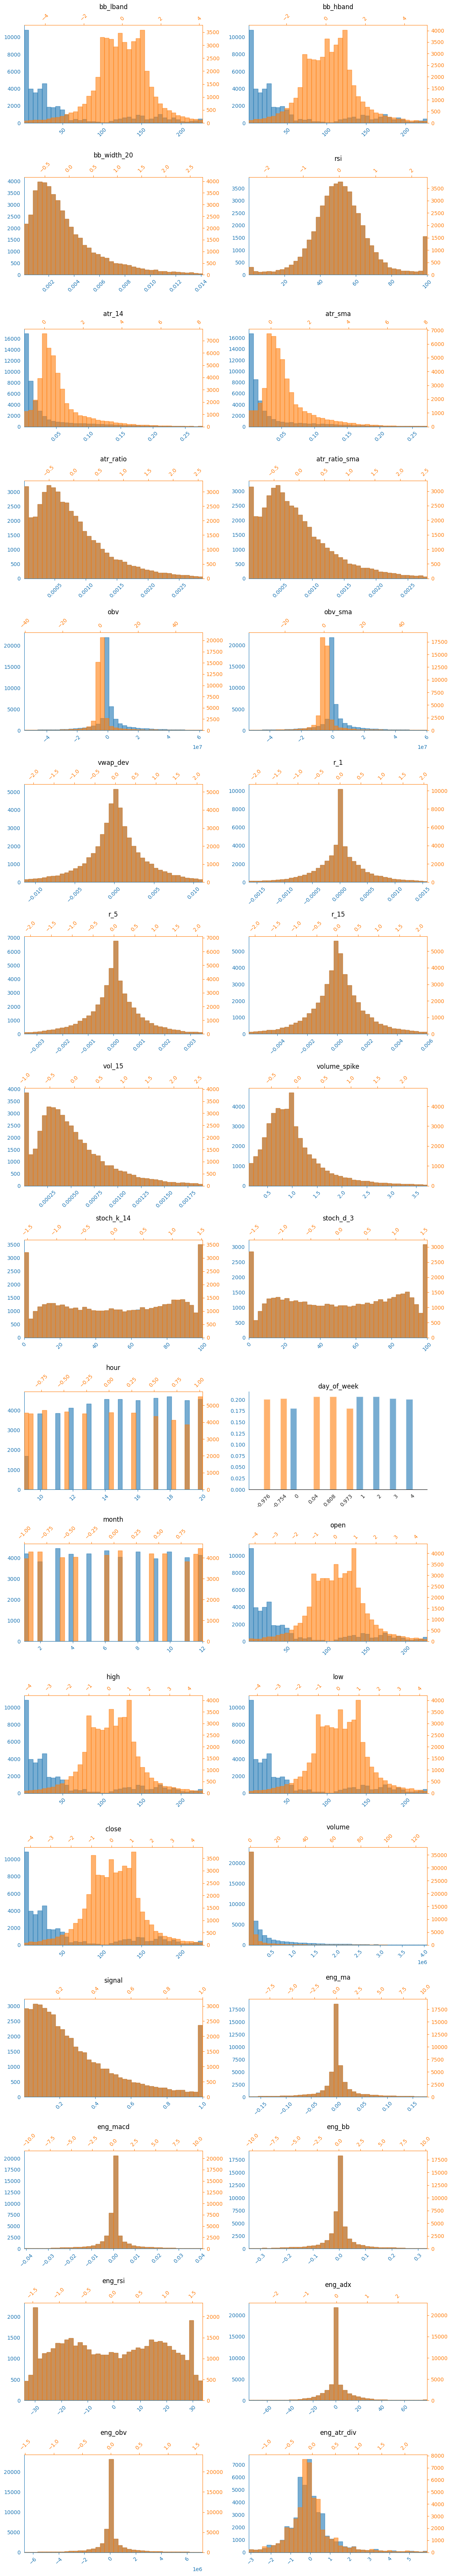

In [7]:
df_feat_scal = df_feat_all.drop(['bid','ask'], axis=1)

plots.plot_dual_histograms(
    df_before = df_feat_unsc,
    df_after  = df_feat_scal,
)